<table width="100%" style="border: none; border-collapse: collapse;">
  <tr>
    <td align="left" width="10%" style="border: none;">
      <img src="logocimat.png" width="120">
    </td>
    <td align="center" width="55%" style="border: none;">
      <h2>Centro de Investigación en Matemáticas, A.C.</h2>
    </td>
    <td align="right" width="25%" style="border: none;">
      <img src="logo_secihti.png" width="350">
    </td>
  </tr>
</table>

<p align="center">
  <img src="logo_insp.png" alt="Logo" width="250"/>
</p>

<h3 align="center">Evaluación de diferentes umbrales para la asignación de la categoría 'Sin etiqueta' en las imagenes 100% etiquetadas</h3>

<h4 align="center">Autor: Sarahi Ventura Angoa</h4>

<p align="center">Maestría en Cómputo Estadístico - CIMAT Mty</p>
<p align="center">Junio 2025</p>


<div class="alert alert-block alert-info">
<strong>Evaluación de estrategias para la asignación de la categoría "Sin etiqueta"</strong><br><br>

Como se mencionó anteriormente, el modelo fue entrenado únicamente con las clases de interés. Sin embargo, al tratarse de imágenes urbanas, existen superpíxeles que contienen objetos o estructuras que <b>no pertenecen a ninguna de las clases entrenadas</b>, como automóviles, tinacos, postes, entre otros. Además, durante el proceso de segmentación, es común que se generen superpíxeles que mezclan coberturas distintas (por ejemplo, <i>techo de lámina</i> con <i>árbol</i>, o <i>hierba y pasto verde</i> con <i>suelo desnudo</i>), entre otras combinaciones. 

<br>
Por esta razón, surge la necesidad de diseñar una <b>estrategia para asignar la categoría "Sin etiqueta"</b> (clase <code>10</code>) a estos superpíxeles ambiguos.

<br>
En este <code>notebook</code> se evaluarán diferentes umbrales para <b>determinar cuál proporciona la mejor precisión promedio</b>. Para esta prueba, se seleccionaron imágenes que fueron <b>etiquetadas manualmente al 100%</b>, incluyendo la categoría "Sin etiqueta". Cabe destacar que, lógicamente, estas imágenes no fueron utilizadas durante el entrenamiento del modelo.

<br>
Estas mismas imágenes también fueron clasificadas automáticamente por el modelo previamente entrenado. Además de obtener la <code>prediction</code> de cada superpíxel, se extrajeron las <b>probabilidades por clase</b> las cuales estan ordenadas de mayor a menor, y algunas diferencias de probabilidades:

<ul>
    <li><code>1_proba_max</code>: probabilidad más alta.</li>
    <li><code>2_proba_max</code>: segunda probabilidad más alta.</li>
    <li><code>3_proba_max</code>, ..., hasta la probabilidad mínima.</li>
  </ul>

  
Por qué se guardan estas probabilidades ordenadas? Porque, al segmentar la imagen, se generan superpíxeles que a veces contienen una mezcla de coberturas (por ejemplo, <i>techo de lámina</i> con <i>árbol</i>, o <i>hierba y pasto verde</i> con <i>suelo desnudo</i>).<br><br>


Además de las columnas anteriores, como se menciona tambien se añadieron al <code>DataFrame</code> las siguientes columnas de diferencias entre probabilidades: 
<ul>
    <li><code>dif_1ra_2da_prob</code>: diferencia entre la probabilidad más alta y la segunda más alta.</li>
    <li><code>dif_1ra_3ra_prob</code>: diferencia entre la probabilidad más alta menos y la tercera más alta.</li>
</ul>

Esta información permitira implementar diferentes estrategias para asignar la categoría "Sin etiqueta" donde precisamente estan estos casos ambiguos o desconocidos, pues nos permiten analizar el <b>nivel de confianza</b> del modelo en cada predicción. Las predicciones automáticas fueron generadas en el notebook <code>clasificacion_automatica_img_prueba.ipynb</code>.

<br>
Con esta información, se implementaron distintas estrategias para <b>determinar el umbral óptimo</b>, comparando la certeza del modelo al asignar una categoría con las <b>etiquetas manuales</b>. Más adelante, se detallan las estrategias empleadas, el análisis exploratorio realizado para definir los umbrales y la justificación del umbral elegido.
</div>


<div class="alert alert-block alert-success">
<b>Importacion de las librerias</b></div>


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-block alert-success">
  <b>📁 Rutas de los archivos .csv utilizados en la evaluación</b><br><br>
  • <code>Caract_paralelo_{nombre_imagen}.csv</code>: Contiene la predicción por superpíxel realizada por el modelo previamente entrenado.<br>
  • <code>Etiquetado_{nombre_imagen}.csv</code>: Contiene la etiqueta asignada manualmente a cada superpíxel (etiquetado de referencia o "ground truth").
</div>



In [2]:
# Rutas

# Carpeta donde están las img de prueba y los archivos Etiquetado_ .csv y el .tif
ruta_carpeta_imagenes = "C:/Users/DELL/Documents/tesis/tesis_visual_code/Imagenes_prueba_etiquetadas_100"  # Carpeta donde están las img de prueba y los archivos Etiquetado_ .csv y el .tif

# Carpeta donde están los archivos Caract_paralelo y los .tif  
ruta_salida_csv = "C:/Users/DELL/Documents/tesis/tesis_visual_code/estrrategias_asignacion_sin_etiqueta"  # Carpeta donde se guardaran los .csv predichos por el modelo y los .tif Caract_paralelo_


In [3]:
print("\n Archivos en la carpeta de IMÁGENES / ETIQUETAS MANUALES:")
for f in sorted(os.listdir(ruta_carpeta_imagenes)):
    if f.lower().endswith(".csv"):
        print(f" - {f}")
print("\n Archivos en la carpeta de PREDICCIONES DEL MODELO:")
for f in sorted(os.listdir(ruta_salida_csv)):
    if f.lower().endswith(".csv"):
        print(f" - {f}")


 Archivos en la carpeta de IMÁGENES / ETIQUETAS MANUALES:
 - Etiquetado_image_x5_1272.csv
 - Etiquetado_image_x5_163.csv
 - Etiquetado_image_x5_164.csv
 - Etiquetado_image_x5_172.csv
 - Etiquetado_image_x5_1730.csv
 - Etiquetado_image_x5_174.csv
 - Etiquetado_image_x5_176.csv
 - Etiquetado_image_x5_1797.csv
 - Etiquetado_image_x5_181.csv
 - Etiquetado_image_x5_201.csv
 - Etiquetado_image_x5_221.csv
 - Etiquetado_image_x5_2448.csv
 - Etiquetado_image_x5_2471.csv
 - Etiquetado_image_x5_2486.csv
 - Etiquetado_image_x5_250.csv
 - Etiquetado_image_x5_2502.csv
 - Etiquetado_image_x5_2868.csv
 - Etiquetado_image_x5_2983.csv
 - Etiquetado_image_x5_3378.csv
 - Etiquetado_image_x5_3425.csv
 - Etiquetado_image_x5_3628.csv
 - Etiquetado_image_x5_3913.csv
 - Etiquetado_image_x5_4037.csv
 - Etiquetado_image_x5_627.csv

 Archivos en la carpeta de PREDICCIONES DEL MODELO:
 - Caract_paralelo_image_x5_1272.csv
 - Caract_paralelo_image_x5_163.csv
 - Caract_paralelo_image_x5_164.csv
 - Caract_paralelo_im

In [4]:
# --------------------------------------------
#  Diccionario de categorías con sus nombres
# --------------------------------------------
categorias = {
    0:  "Árbol",
    1:  "Suelo desnudo",
    2:  "Pavimento",
    3:  "Cuerpo de agua",
    4:  "Techo de lámina",
    5:  "Techo de losa",
    6:  "Arbusto",
    7:  "Hierba y pasto seco",
    8:  "Hierba y pasto verde",
    9:  "Sombra",
    10: "Sin etiqueta"   # Se asigna cuando el modelo está incierto
}

In [5]:
# ============================================
# UNIR TODAS LAS IMÁGENES EN UN SOLO DATAFRAME
# ============================================

# Obtener todos los archivos Caract_paralelo
archivos_caract = [f for f in os.listdir(ruta_salida_csv) if f.startswith("Caract_paralelo") and f.endswith(".csv")]

import pandas as pd
import os

# Lista donde vamos a guardar los datos de TODAS las imágenes
datos_todas_imagenes = []

for archivo_caract in archivos_caract:
    # -----------------------------------------
    # Obtener nombre base de la imagen
    # -----------------------------------------
    nombre_imagen = archivo_caract.replace("Caract_paralelo_", "").replace(".csv", "")
    archivo_etiquetado_manualmente = f"Etiquetado_{nombre_imagen}.csv"
    ruta_completa_etiquetado = os.path.join(ruta_carpeta_imagenes, archivo_etiquetado_manualmente)

    # -----------------------------------------
    # Verificar que existe el archivo de etiquetado manual
    # -----------------------------------------
    if not os.path.exists(ruta_completa_etiquetado):
        print(f"  Archivo no encontrado: {archivo_etiquetado_manualmente}. Saltando...")
        continue

    # -----------------------------------------
    # Columnas de interes del archivo de Caract_paralelo
    # -----------------------------------------
    df_caract = pd.read_csv(
        os.path.join(ruta_salida_csv, archivo_caract),
        usecols=["indice", "prediction", "1_proba_max", "2_proba_max",
                "3_proba_max", "4_proba_max", "5_proba_max", "6_proba_max",
                "7_proba_max", "8_proba_max", "9_proba_max", "10_proba_max","dif_1ra_2da_prob", "dif_1ra_3ra_prob"]
    )

    # -----------------------------------------
    # Columnas de interes del archivo de Etiquetado_
    # -----------------------------------------
    df_etiquetado = pd.read_csv(
        ruta_completa_etiquetado,
        usecols=["indice", "categoria"]
    )

    # -----------------------------------------
    # Unir por indice
    # -----------------------------------------
    df_comparacion = df_etiquetado.merge(
        df_caract,
        on="indice",
        how="left"
    )

    # -----------------------------------------
    # Agregar columna de nombre de imagen
    # -----------------------------------------
    df_comparacion["imagen"] = nombre_imagen

    # -----------------------------------------
    # Guardar en la lista general
    # -----------------------------------------
    datos_todas_imagenes.append(df_comparacion[["imagen", "indice", "categoria",     
                                                "prediction", "1_proba_max", "2_proba_max",
                                                "3_proba_max", "4_proba_max", "5_proba_max", "6_proba_max",
                                                "7_proba_max", "8_proba_max", "9_proba_max", "10_proba_max",
                                                "dif_1ra_2da_prob", "dif_1ra_3ra_prob"]])

# ============================================
# Concatenar TODAS las imágenes en UN SOLO DataFrame
# ============================================
df_completo_etiquetado_predicciones_original = pd.concat(datos_todas_imagenes, ignore_index=True)

print("\n DataFrame UNIDO con la infromacion de todas las images")
print(df_completo_etiquetado_predicciones_original.head())
print(f"Total de superpíxeles en TODO el dataset: {len(df_completo_etiquetado_predicciones_original)}")



 DataFrame UNIDO con la infromacion de todas las images
          imagen  indice  categoria  prediction  1_proba_max  2_proba_max  \
0  image_x5_1272    45.0        5.0           4     0.506763     0.165645   
1  image_x5_1272     6.0        5.0           4     0.378005     0.218029   
2  image_x5_1272     7.0        5.0           2     0.354175     0.310305   
3  image_x5_1272    67.0        5.0           4     0.448126     0.190227   
4  image_x5_1272     8.0        5.0           4     0.318171     0.251115   

   3_proba_max  4_proba_max  5_proba_max  6_proba_max  7_proba_max  \
0     0.149438     0.085669     0.039091     0.020000     0.015939   
1     0.170916     0.080050     0.058768     0.049351     0.022500   
2     0.240238     0.056949     0.021667     0.016667     0.000000   
3     0.130289     0.091896     0.072869     0.021538     0.020952   
4     0.197045     0.078524     0.056190     0.051714     0.033372   

   8_proba_max  9_proba_max  10_proba_max  dif_1ra_2da_prob

<div class="alert alert-block alert-info">
<stong>Función para medir el desempeño por modelo para cada umbral, para cada clase y de forma global</strong><br>

<ul>
    <li>Aqui cada fila representa las instancias reales de una clase específica <i>clase verdadera </i> según el etiquetado manual </li>
    <li>cada columna indica cuántas veces el modelo predijo esa clase <i>prediction</i> </li>
</ul>
</div>

In [6]:
def calcular_metricas_clases_con_resumen(df,
                                         col_real="categoria",
                                         col_pred="pred_estrat_1",
                                         categorias=None,
                                         clase_sin_etiqueta=10,
                                         incluir_sin_etiqueta=False):
    metricas = []
    clases = sorted(set(df[col_real].unique()) | set(df[col_pred].unique()))
    total_soporte = len(df)

    TP_total, FP_total, FN_total = 0, 0, 0

    for clase in clases:
        # nombre de la clase
        nombre = categorias.get(clase, f"Clase_{clase}") if categorias else f"Clase_{clase}"

        # True positives: predicción correcta, tanto la clase real como la predicha son iguales
        TP = ((df[col_real] == clase) & (df[col_pred] == clase)).sum()
        # Falses positives (FP): el modelo predijo esta clase, pero en realidad era otra (errores a lo largo de la columna i)
        FP = ((df[col_real] != clase) & (df[col_pred] == clase)).sum()
        # Falses negatives (FN): la instancia era realmente de esta clase, pero el modelo predijo otra (errores a lo largo de la fila j)
        FN = ((df[col_real] == clase) & (df[col_pred] != clase)).sum()
        # True negatives (TN): todas las instancias que no eran ni reales ni predichas como esta clase
        TN = ((df[col_real] != clase) & (df[col_pred] != clase)).sum()

        # Soporte: número de veces que esta clase aparece como verdadera (frecuencia real)
        soporte = (df[col_real] == clase).sum()
        # Peso relativo de esta clase (w_i), basado en su proporción del total
        peso = soporte / total_soporte if total_soporte > 0 else 0

        # -------------------------------------------------------------------------------------
        # Calculo de las métricas Accuracy, Presicion, Recall y F1-score 
        # ------------------------------------------------------------------------------------ 
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        TP_total += TP
        FP_total += FP
        FN_total += FN

        metricas.append({
            "Clase": nombre,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "Soporte": soporte,
            "Peso w_i": peso,
            "Accuracy": accuracy,
            "Precisión": precision,
            "Recall": recall,
            "F1-score": f1,
            "w_i * Precisión": peso * precision,
            "w_i * Recall": peso * recall,
            "w_i * F1": peso * f1
        })

    df_metricas = pd.DataFrame(metricas)

    # Filtrar clase "Sin etiqueta" si no se quiere incluir
    if not incluir_sin_etiqueta and categorias:
        nombre_sin = categorias.get(clase_sin_etiqueta, "Sin etiqueta")
        df_filtrado = df_metricas[df_metricas["Clase"] != nombre_sin]
    else:
        df_filtrado = df_metricas

    # -------------------------------------------------------------------------------------
    # Calcular Macro-average y Weighted-average y Micro-average
    # ------------------------------------------------------------------------------------

    macro_precision = df_filtrado["Precisión"].mean()
    macro_recall = df_filtrado["Recall"].mean()
    macro_f1 = df_filtrado["F1-score"].mean()

    weighted_precision = df_filtrado["w_i * Precisión"].sum()
    weighted_recall = df_filtrado["w_i * Recall"].sum()
    weighted_f1 = df_filtrado["w_i * F1"].sum()

    precision_micro = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0.0
    recall_micro = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0.0
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro) if (precision_micro + recall_micro) > 0 else 0.0

    metricas_globales = {
        "Precision_weighted": weighted_precision,
        "Recall_weighted": weighted_recall,
        "F1_weighted": weighted_f1,
        "Precision_macro": macro_precision,
        "Recall_macro": macro_recall,
        "F1_macro": macro_f1,
        "Precision_micro": precision_micro,
        "Recall_micro": recall_micro,
        "F1_micro": f1_micro
    }

    return df_metricas, metricas_globales


<div class="alert alert-block alert-warning">

<b>🎯 Estrategia 2: Asignación de la categoría "Sin etiqueta" considerando la primera y tercera probabilida más alta</b><br><br>

En esta segunda estrategia se aprovecha la métrica <b>diferencia entre la probabilidad menos la tercera más altas</b> (<code>dif_1ra_3ra_prob</code>) como indicador de certeza del modelo. Cuando esta diferencia es **baja o negativa**, significa que la predicción está <b>distribuida entre tres clases competidoras</b>, indicando alta incertidumbre.<br><br>

Se aplica la siguiente regla de asignación:<br>
<blockquote>
  Si <code>dif_1ra_3ra_prob &lt; umbral</code>, entonces se asigna la categoría <code>10</code> ("Sin etiqueta").
</blockquote>

Esta estrategia busca identificar no solo la ambigüedad entre dos clases principales, sino también los casos donde hay <b>mezcla significativa con una tercera opción</b>. Al detectar estos escenarios, se etiquetan como "Sin etiqueta" para evitar asignaciones erróneas.<br><br>

Al igual que en la Estrategia 1, se realizará un <b>análisis exploratorio</b> de la distribución de estas diferencias para decidir un rango de umbrales a evaluar, donde se comparan las predicciones ajustadas con esta estrategia contra las etiquetas manuales, con el objetivo de <b>determinar cuál umbral proporciona el mejor el equilibrio entre las metricas globales y por categoria, minimizando predicciones erróneas a costa de aceptar más "Sin etiqueta" en los casos dudosos.

</div>

<div class="alert alert-block alert-success">
  <b>🔎 Análisis exploratorio para establecer el rango del umbral</b><br><br>
</div>


In [7]:
import pandas as pd
import os

# Lista para guardar todas las diferencias de la segunda estrategia
todas_dif_1ra_3ra = []

for archivo in archivos_caract:
    ruta_completa = os.path.join(ruta_salida_csv, archivo)
    
    try:
        # Cargar solo la columna de interés
        df = pd.read_csv(ruta_completa, usecols=["dif_1ra_3ra_prob"])
        
        # Agregar todos los valores de la columna a la lista
        todas_dif_1ra_3ra.extend(df["dif_1ra_3ra_prob"].tolist())
    
    except Exception as e:
        print(f"Error con archivo {archivo}: {e}")


<div class="alert alert-block alert-success">
  <b>📊 Resumen estadístico</b><br><br>
  Se presenta un resumen numérico (mínimo, máximo, media, mediana, varianza, desviación estándar) para describir la dispersión y tendencia central de las diferencias de probabilidad.
</div>

In [8]:
print("\n--- Resumen estadístico ---")
print("dif_1ra_3ra_prob")
print(f"  Mínimo  : {np.min(todas_dif_1ra_3ra):.4f}")
print(f"  Máximo  : {np.max(todas_dif_1ra_3ra):.4f}")
print(f"  Media   : {np.mean(todas_dif_1ra_3ra):.4f}")
print(f"  Mediana : {np.median(todas_dif_1ra_3ra):.4f}")
print(f"  Varianza: {np.var(todas_dif_1ra_3ra):.4f}")
print(f"  Desv. estándar: {np.std(todas_dif_1ra_3ra):.4f}")



--- Resumen estadístico ---
dif_1ra_3ra_prob
  Mínimo  : 0.0016
  Máximo  : 1.0000
  Media   : 0.4795
  Mediana : 0.4546
  Varianza: 0.0737
  Desv. estándar: 0.2715


<div class="alert alert-block alert-success">
  <b>📈 Histogramas de frecuencia absolutas de las diferencia entre la probabilidad más alta y la tercera más alta.</b> <br>
  Este gráfico permiten visualizar en qué rangos se concentran los casos más ambiguos y establecer sobre que intervalo probar los umbrales.
  <ul>
    <li>En el eje X se muestran los intervalos (bins) de la variable todas_dif_1ra_3ra. </li>
    <li> En el eje Y se muestra cuántos valores caen en cada intervalo (frecuencia absolua)</li>
  </ul>
</div>


[dif_1ra_3ra_prob] Pico más alto del histograma entre 0.261 y 0.281


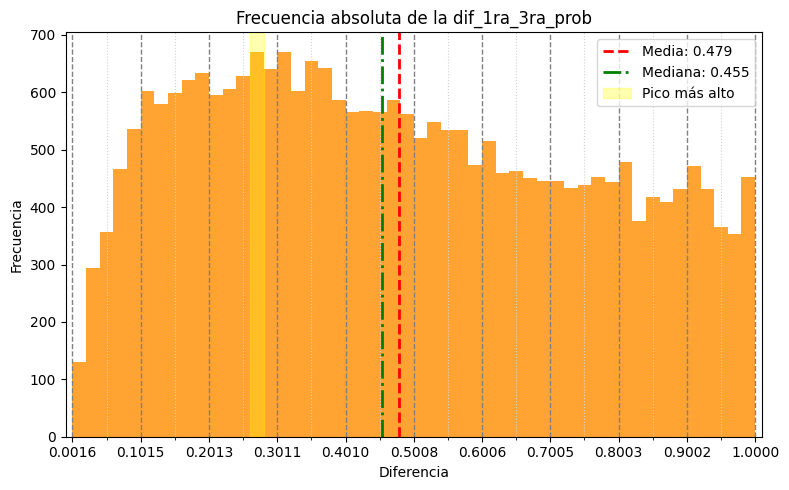

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------
# Calcular estadísticas
# ---------------------------------------

media_1ra_3ra = np.mean(todas_dif_1ra_3ra)
mediana_1ra_3ra = np.median(todas_dif_1ra_3ra)


# ---------------------------------------
# Calcular picos de histograma
# ---------------------------------------
counts_1, bin_edges_1 = np.histogram(todas_dif_1ra_3ra, bins=50)
pico_inicio_1 = bin_edges_1[np.argmax(counts_1)]
pico_fin_1 = bin_edges_1[np.argmax(counts_1) + 1]

print(f"[dif_1ra_3ra_prob] Pico más alto del histograma entre {pico_inicio_1:.3f} y {pico_fin_1:.3f}")

# ---------------------------------------
# Determinar rangos dinámicos de los ejes
# ---------------------------------------
minimo_1ra_3ra = np.min(todas_dif_1ra_3ra)
maximo_1ra_3ra = np.max(todas_dif_1ra_3ra)

# ---------------------------------------
# Crear figura y eje
# ---------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

# ---------------------------------------
# Histograma
# ---------------------------------------
ax.hist(todas_dif_1ra_3ra, bins=50,color='darkorange', alpha=0.8)
ax.axvline(media_1ra_3ra, color='red', linestyle='--', linewidth=2, label=f"Media: {media_1ra_3ra:.3f}")
ax.axvline(mediana_1ra_3ra, color='green', linestyle='-.', linewidth=2, label=f"Mediana: {mediana_1ra_3ra:.3f}")
ax.axvspan(pico_inicio_1, pico_fin_1, color='yellow', alpha=0.3, label='Pico más alto')

ax.set_title("Frecuencia absoluta de la dif_1ra_3ra_prob")
ax.set_xlabel("Diferencia")
ax.set_ylabel("Frecuencia")
ax.legend()

# Ajustar límites del eje X dinámicamente
ax.set_xlim(minimo_1ra_3ra - 0.01, maximo_1ra_3ra + 0.01)

# Ajustar ticks principales y secundarios dinámicos
ticks_major_1 = np.linspace(minimo_1ra_3ra, maximo_1ra_3ra, 11)
ticks_minor_1 = np.linspace(minimo_1ra_3ra, maximo_1ra_3ra, 21)
ax.set_xticks(ticks_major_1)
ax.set_xticks(ticks_minor_1, minor=True)

ax.grid(which='major', axis='x', color='gray', linestyle='--', linewidth=1.0)
ax.grid(which='minor', axis='x', color='lightgray', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()

<div class="alert alert-info">

<b>📊 Conclusiones del gráfico de frecuencias de <code>dif_1ra_3ra_prob</code></b><br><br>

Las barras del histograma tienen un ancho aproximado de 0.025.<br><br>

La mayor concentración de frecuencias se encuentra entre aproximadamente <b>0.1015 y 0.4010</b>, es decir, hacia el lado izquierdo del gráfico. Esto evidencia que el modelo <b>frecuentemente está indeciso o no tan seguro</b> al clasificar.<br><br>

Se observa un <b>pico destacado entre 0.261 y 0.281</b> (área amarilla sombreada), y otro muy similar entre <b>0.31 y 0.36</b>. El gráfico comienza en <b>0.0016</b>, donde las frecuencias son bajas, pero a partir de ese punto se incrementan con ligeras fluctuaciones hasta alcanzar el pico máximo.<br><br>

Después del pico, la frecuencia comienza a disminuir ligeramente, mostrando algunas mesetas y pequeñas ondulaciones. En particular, hay una sección relativamente plana entre <b>0.8056 y 0.8003</b>, y a partir de ahí el gráfico sigue con una tendencia estable y frecuencias algo dispersas.<br><br>

Entre <b>0.323 y 1.0</b>, la distribución se aplana aún más, mostrando un patrón más uniforme con ligeras fluctuaciones.<br><br>

El gráfico también señala la <b>media</b> (línea roja punteada) y la <b>mediana</b> (línea verde punteada), que sirven como referencias de tendencia central.<br><br>

<hr>

<b>🎯 Ajuste del rango de umbrales</b><br><br>

Tras analizar la distribución de <code>dif_1ra_3ra_prob</code>, se definió un rango más enfocado para la evaluación de umbrales:<br><br>

<blockquote>
  <code>np.arange(0, 0.36, 0.01)</code>
</blockquote>

Esto significa:<br>
<ul>
  <li><b>start = 0</b>: valor inicial.</li>
  <li><b>stop = 0.36</b>: valor final (el rango se detiene justo antes de 0.36,).</li>
  <li><b>step = 0.01</b>: incremento pequeño, que permite un ajuste fino en el análisis.</li>
</ul>

Con este rango se busca <b>evaluar más a detalle</b> el comportamiento del modelo frente a distintos umbrales, con el objetivo de lograr un <b>buen equilibrio</b> entre:
<ul>
  <li>Maximizar las métricas de desempeño general.</li>
  <li>Filtrar con mayor certeza las predicciones más inciertas (asignadas a la clase <code>10</code>).</li>
</ul>

</div>


In [10]:
umbrales_estrategia_2 = np.arange(0.0, 0.36, 0.01)  
resultados_umbral_estrategia_2 = []

In [11]:
lista_porcentaje_sin_etiqueta_umbral = []
lista_metricas_globales = []

lista_metricas_todos_los_umbral = []

for umbral in umbrales_estrategia_2:
    print(f"\n=======================")
    print(f" Evaluando UMBRAL: {umbral:.3f}")
    print("=======================\n")
    # -----------------------------------------
    # Aplicar el umbral para todas las filas
    # -----------------------------------------

    # Copiamos el DataFrame original para no modificarlo
    df_umbral = df_completo_etiquetado_predicciones_original.copy()

    # Inicializamos la columna de predicción filtrada por estrategia 2
    df_umbral["pred_estrat_2"] = df_umbral["prediction"]
    
    # Si la diferencia de probabilidad es menor al umbral, asignamos "Sin etiqueta" (10)
    df_umbral.loc[df_umbral["dif_1ra_3ra_prob"] < umbral, "pred_estrat_2"] = 10

    # ----------------------------------------------------
    # Contar cuántos superpíxeles quedan "Sin etiqueta"
    # ----------------------------------------------------

    total_superpixeles_global = len(df_umbral) 
    total_sin_etiqueta  = (df_umbral["pred_estrat_2"] == 10).sum()
    porcentaje_sin_etiqueta = 100 * total_sin_etiqueta / total_superpixeles_global

    # -------------------------------------------------------------------------------------------
    # llamada de la funcion para el calculo de las metricas por clase y globales para cada Umbral
    #-----------------------------------------------------------------------------------------
    df_clase, metricas_globales = calcular_metricas_clases_con_resumen(
        df_umbral,
        col_real="categoria",
        col_pred="pred_estrat_2",
        categorias=categorias,
        clase_sin_etiqueta=10,
        incluir_sin_etiqueta=True  # O False para NO incluir la categoria sin etiqueta, o True para SI incluir la categoría sin etiqueta
    )

    # Redondear los valores de la impresion
    num_decimales = 6
    metricas_clase = df_clase[[
        "Clase", "TP", "FP", "FN", "Soporte", "Peso w_i", "Accuracy", "Precisión", "Recall", "F1-score",
        "w_i * Precisión", "w_i * Recall", "w_i * F1"
    ]].copy()
    # Agregar el umbral como columna
    metricas_clase["Umbral"] = umbral   
    metricas_clase = metricas_clase.round(num_decimales)
    print(metricas_clase.to_string(index=False))  # Impresión estilo tabla

    lista_metricas_todos_los_umbral.append(metricas_clase.copy())

    # Guardar el porcentaje de sin etiqueta para cada umbral
    lista_porcentaje_sin_etiqueta_umbral.append({
        "Umbral": umbral,
        "Porcentaje_SinEtiqueta": porcentaje_sin_etiqueta})

    # Globales
    print(f"Precision_weighted: {metricas_globales['Precision_weighted']:.3f}")
    print(f"Recall_weighted: {metricas_globales['Recall_weighted']:.3f}")
    print(f"F1_weighted: {metricas_globales['F1_weighted']:.3f}")
    print(f"Precision_macro: {metricas_globales['Precision_macro']:.3f}")
    print(f"Recall_macro: {metricas_globales['Recall_macro']:.3f}")
    print(f"F1_macro: {metricas_globales['F1_macro']:.3f}")
    print(f"Precision_micro: {metricas_globales['Precision_micro']:.3f}")
    print(f"Recall_micro: {metricas_globales['Recall_micro']:.3f}")
    print(f"F1_micro: {metricas_globales['F1_micro']:.3f}")

    fila_global = {
    "Umbral": umbral,
    "Porcentaje_SinEtiqueta": porcentaje_sin_etiqueta,
    **metricas_globales
    }
    lista_metricas_globales.append(fila_global)

df_porcentajes_sin_etiqueta = pd.DataFrame(lista_porcentaje_sin_etiqueta_umbral)
df_metricas_globales_umbral = pd.DataFrame(lista_metricas_globales)

df_metricas_todos_los_umbral = pd.concat(lista_metricas_todos_los_umbral, ignore_index=True)



 Evaluando UMBRAL: 0.000

               Clase   TP   FP   FN  Soporte  Peso w_i  Accuracy  Precisión   Recall  F1-score  w_i * Precisión  w_i * Recall  w_i * F1  Umbral
               Árbol 1991 5248  350     2341  0.093580  0.776223   0.275038 0.850491  0.415658         0.025738      0.079589  0.038897     0.0
       Suelo desnudo 1769 1942 1042     2811  0.112368  0.880716   0.476691 0.629313  0.542472         0.053565      0.070715  0.060956     0.0
           Pavimento  930  691  894     1824  0.072913  0.936641   0.573720 0.509868  0.539913         0.041832      0.037176  0.039367     0.0
      Cuerpo de agua  352   37  277      629  0.025144  0.987448   0.904884 0.559618  0.691552         0.022752      0.014071  0.017388     0.0
     Techo de lámina 3436 1811  278     3714  0.148465  0.916493   0.654850 0.925148  0.766879         0.097222      0.137352  0.113855     0.0
       Techo de losa  569  825 1164     1733  0.069276  0.920491   0.408178 0.328332  0.363927         0.0282

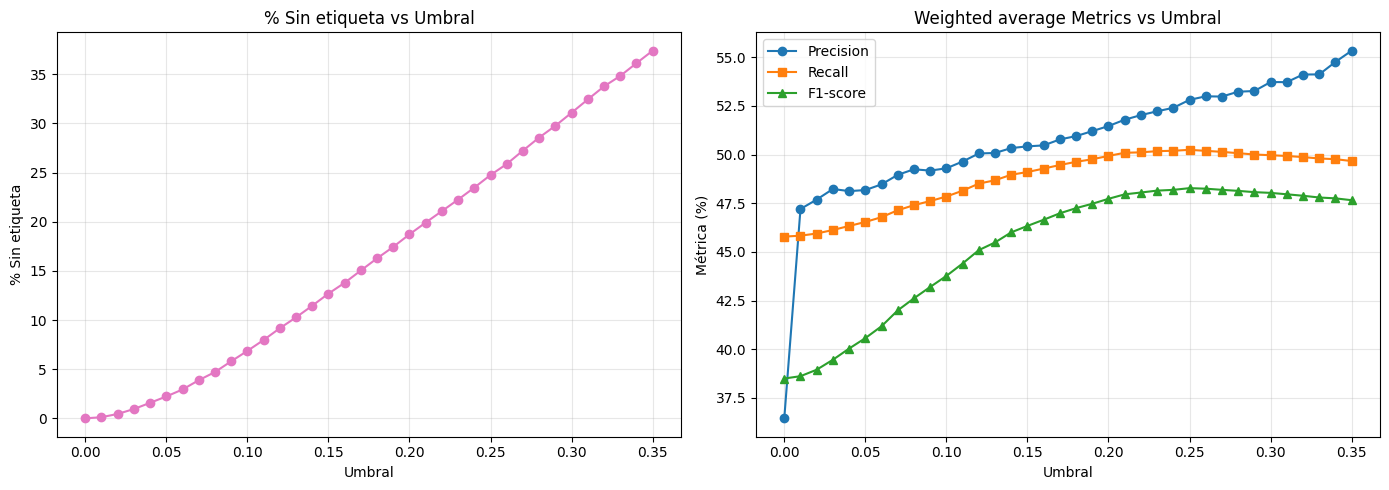

In [12]:
import matplotlib.pyplot as plt

# Crear figura con dos subgráficos en una cuadrícula 2x2
fig, axes = plt.subplots(ncols=2, figsize=(14, 5)) 


# --------------------------------------------
# GRÁFICO 1: Umbral vs % Sin etiqueta
# --------------------------------------------
axes[0].plot(
    df_porcentajes_sin_etiqueta["Umbral"],
    df_porcentajes_sin_etiqueta["Porcentaje_SinEtiqueta"],
    marker='o',
    color='tab:pink'
)
axes[0].set_title("% Sin etiqueta vs Umbral")
axes[0].set_xlabel("Umbral")
axes[0].set_ylabel("% Sin etiqueta")
axes[0].grid(alpha=0.3)

# --------------------------------------------
# GRÁFICO 2: Umbral vs métricas  Weighted
# --------------------------------------------
axes[1].plot(
    df_metricas_globales_umbral["Umbral"],
    100 * df_metricas_globales_umbral["Precision_weighted"],
    label="Precision", marker='o'
)
axes[1].plot(
    df_metricas_globales_umbral["Umbral"],
    100 * df_metricas_globales_umbral["Recall_weighted"],
    label="Recall", marker='s'
)
axes[1].plot(
    df_metricas_globales_umbral["Umbral"],
    100 * df_metricas_globales_umbral["F1_weighted"],
    label="F1-score", marker='^'
)

axes[1].set_title("Weighted average Metrics vs Umbral")
axes[1].set_xlabel("Umbral")
axes[1].set_ylabel("Métrica (%)")
axes[1].legend()
axes[1].grid(alpha=0.3)


# Ajustar espacios
plt.tight_layout()
plt.show()


<div class="alert alert-info">

<h4>📊 Interpretación de las métricas y selección del umbral</h4>

<h5>🔹 Métricas <u>Weighted</u></h5>

<ul>
  <li>El <b>F1-score Weighted</b> aumenta progresivamente hasta el <b>umbral = 0.25</b>, y luego comienza a disminuir ligeramente. Sin embargo, se observa una <b>meseta</b> estable entre los umbrales <b>0.22 y 0.33</b>.</li>

  <li>La <b>Precisión Weighted</b> sigue creciendo conforme se incrementa el umbral.</li>

  <li>El <b>Recall Weighted</b> crece de forma progresiva hasta alcanzar su máximo en el <b>umbral = 0.25</b>, pero se mantiene prácticamente estable desde <b>0.20 hasta 0.34</b>.</li>
</ul>

<hr>

<h5>🟨 Impacto del umbral y la clase “<code>Sin etiqueta</code>”</h5>

<p>
A medida que el <b>umbral aumenta</b>, más superpíxeles son clasificados como <code>Sin etiqueta</code>, ya que la diferencia entre las probabilidades analizadas no supera el umbral definido. Esto implica que el modelo solo etiqueta cuando está más seguro, lo cual <b>mejora la precisión</b>, aunque el <b>recall</b> no mejora mucho, sino que se estabiliza.
</p>

</div>

<div style="background-color:#fff3cd; padding: 12px; border-left: 5px solid #ffc107; font-size: 15px;">
  <strong>🎯 Recomendación:</strong> Un umbral entre <strong>0.20 y 0.25</strong> ofrece un buen balance entre precisión, recall, f1-score y cobertura.<br>
  De forma más específica, y de acuerdo al análisis realizado, se sugiere utilizar el <strong>umbral = 0.20</strong>, ya que en este punto el modelo no clasifica como <code>Sin etiqueta</code> a tantos superpíxeles, manteniendo una buena cobertura sin comprometer demasiado la certeza.
</div>



<div class="alert alert-block alert-success">
  <strong>📊 Grafica de desempeño por clase frente a distintos umbrales de asignación de la clase 'Sin etiqueta'</strong><br>
</div>

In [13]:
# Pivotar el DataFrame para tener umbrales como índice y clases como columnas
df_accu_prec_recall_f1_pivot = df_metricas_todos_los_umbral.pivot(
    index="Umbral", columns="Clase", values=["Accuracy", "Precisión", "Recall", "F1-score"]
)

categorias = [
    'Árbol',
    'Suelo desnudo',
    'Pavimento',
    'Cuerpo de agua',
    'Techo de lámina',
    'Techo de losa',
    'Arbusto',
    'Hierba y pasto seco',
    'Hierba y pasto verde',
    'Sombra',
    'Sin etiqueta'
]

# Diccionario de colores
color_dict = {
    'Árbol': (0,139,69), 
    'Suelo desnudo': (255, 153, 18), 
    'Pavimento': (104, 131, 139), 
    'Cuerpo de agua': (61, 85, 171), 
    'Techo de lámina': (205, 104, 137), 
    'Techo de losa': (128,0,0),
    'Arbusto': (47, 107, 85),
    'Hierba y pasto seco': (255, 255, 0),
    'Hierba y pasto verde': (0, 252, 124),
    'Sombra': (105, 105, 105),
    'Sin etiqueta': (0, 0, 0)
}

# Colores normalizados en el orden correcto
colores_rgb_norm = [np.array(color_dict[cat]) / 255.0 for cat in categorias]


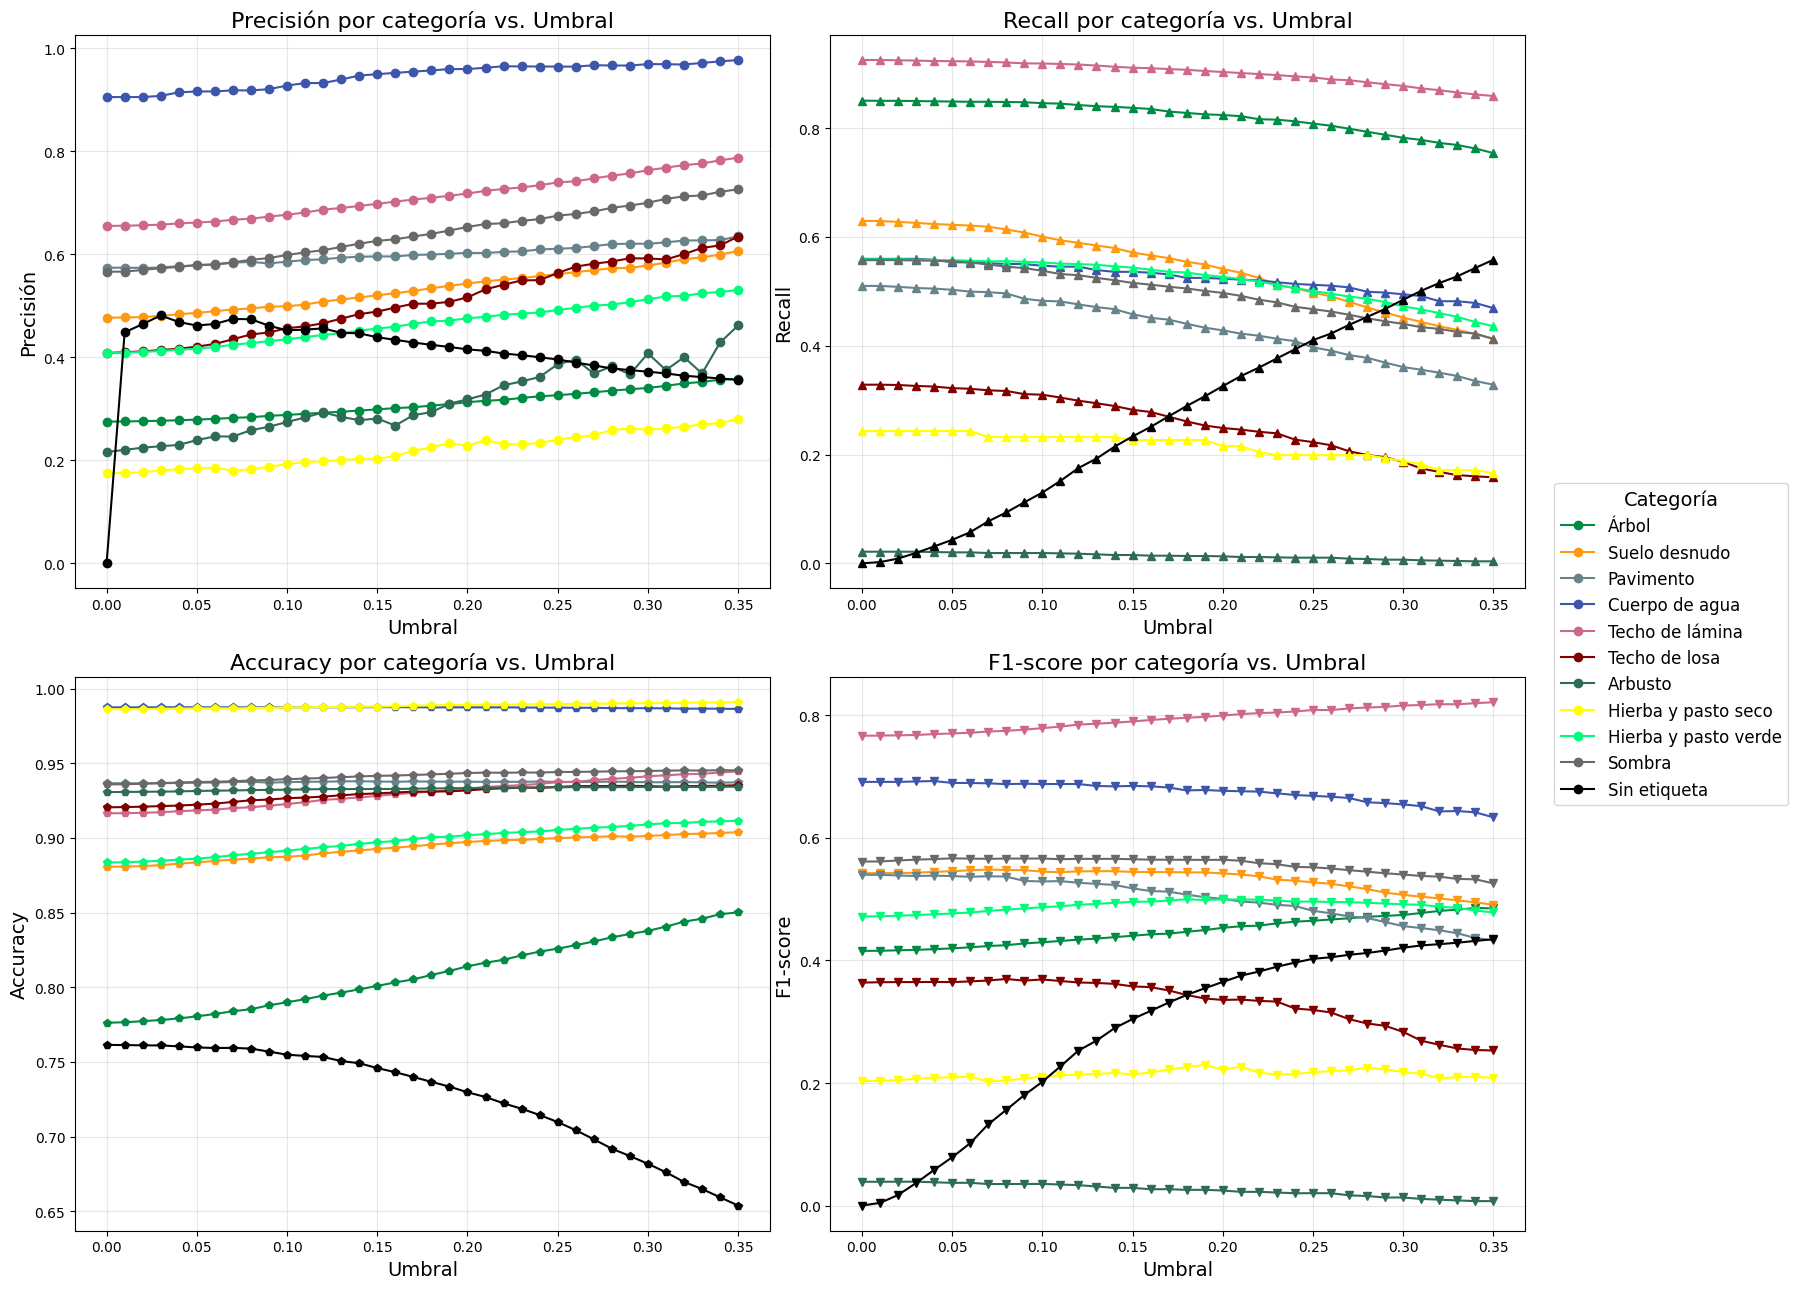

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Crear figura
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 13))

# -------------------------------------------------------
# Gráfico 1: Precisión por categoría vs Umbral
# -------------------------------------------------------
for i, clase in enumerate(categorias):
    if clase in df_accu_prec_recall_f1_pivot["Precisión"].columns:
        axes[0,0].plot(
            df_accu_prec_recall_f1_pivot.index,
            df_accu_prec_recall_f1_pivot["Precisión"][clase],
            label=clase,
            color=colores_rgb_norm[i],
            marker='o'
        )

axes[0,0].set_title("Precisión por categoría vs. Umbral", fontsize=16)
axes[0,0].set_xlabel("Umbral", fontsize=14)
axes[0,0].set_ylabel("Precisión", fontsize=14)
axes[0,0].grid(alpha=0.3)

# -------------------------------------------------------
# Gráfico 2: Recall por categoría vs Umbral
# -------------------------------------------------------
for i, clase in enumerate(categorias):
    if clase in df_accu_prec_recall_f1_pivot["Recall"].columns:
        axes[0,1].plot(
            df_accu_prec_recall_f1_pivot.index,
            df_accu_prec_recall_f1_pivot["Recall"][clase],
            label=clase,
            color=colores_rgb_norm[i],
            marker='^'
        )

axes[0,1].set_title("Recall por categoría vs. Umbral", fontsize=16)
axes[0,1].set_xlabel("Umbral", fontsize=14)
axes[0,1].set_ylabel("Recall", fontsize=14)
axes[0,1].grid(alpha=0.3)


# -------------------------------------------------------
# Gráfico 3: Accuracy por categoría vs Umbral
# -------------------------------------------------------
for i, clase in enumerate(categorias):
    if clase in df_accu_prec_recall_f1_pivot["Accuracy"].columns:
        axes[1,0].plot(
            df_accu_prec_recall_f1_pivot.index,
            df_accu_prec_recall_f1_pivot["Accuracy"][clase],
            label=clase,
            color=colores_rgb_norm[i],
            marker='p'
        )

axes[1,0].set_title("Accuracy por categoría vs. Umbral", fontsize=16)
axes[1,0].set_xlabel("Umbral", fontsize=14)
axes[1,0].set_ylabel("Accuracy", fontsize=14)
axes[1,0].grid(alpha=0.3)

# -------------------------------------------------------
# Gráfico 4: F1  por categoría vs Umbral
# -------------------------------------------------------
for i, clase in enumerate(categorias):
    if clase in df_accu_prec_recall_f1_pivot["F1-score"].columns:
        axes[1,1].plot(
            df_accu_prec_recall_f1_pivot.index,
            df_accu_prec_recall_f1_pivot["F1-score"][clase],
            label=clase,
            color=colores_rgb_norm[i],
            marker='v'
        )

axes[1,1].set_title("F1-score por categoría vs. Umbral", fontsize=16)
axes[1,1].set_xlabel("Umbral", fontsize=14)
axes[1,1].set_ylabel("F1-score", fontsize=14)
axes[1,1].grid(alpha=0.3)

# -------------------------------------------------------
# Una sola leyenda general
# -------------------------------------------------------
fig.legend(
    categorias, 
    title="Categoría",
    title_fontsize=14,  # Aumenta el tamaño del título
    fontsize=12,        # Tamaño del texto de las categorías
    loc="center right"
)

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()


Podemos ver que para la presicion la mayoria de las categorias la presicion va subiendo conforme avanza el umbral, es decir en la mayoria de las clases le va bien, solo en pavimento la subida va de manera mas lento y aumenta solo un poco en comparacion con todas las demas clases. en cuanto al recall los valores mas altos se encuentran justo cuando el umbral es 0, y de ahi comienza a bajar de forma progresiva pero moderada, la unica clase que se ve beneficiada conforme va avanzando el umbral es la clase sin etiqueta. Por otro lado el F1-score para unas clasesle beneficia, y para otras no tanto, aunque si hay algunas que muestran mejor desempeño que otras, 

<div class="alert alert-block alert-success">
  <strong>📊 Tabla del valor del F1-score por clase y umbral</strong><br>
</div>

In [14]:
# Paso 1: Crear la tabla resumen F1-score por clase y umbral
tabla_f1_por_umbral = df_metricas_todos_los_umbral.pivot(
    index="Umbral", columns="Clase", values="F1-score"
).reset_index()

# Mostrar (puedes redondear si quieres)
print(tabla_f1_por_umbral.round(3))

Clase  Umbral  Arbusto  Cuerpo de agua  Hierba y pasto seco  \
0        0.00    0.039           0.692                0.203   
1        0.01    0.039           0.692                0.204   
2        0.02    0.039           0.692                0.205   
3        0.03    0.039           0.692                0.207   
4        0.04    0.038           0.693                0.209   
5        0.05    0.037           0.690                0.210   
6        0.06    0.037           0.690                0.211   
7        0.07    0.035           0.689                0.202   
8        0.08    0.035           0.688                0.204   
9        0.09    0.035           0.689                0.207   
10       0.10    0.035           0.688                0.211   
11       0.11    0.034           0.688                0.213   
12       0.12    0.033           0.688                0.214   
13       0.13    0.031           0.685                0.215   
14       0.14    0.029           0.684                0

In [15]:
tabla_f1_por_umbral

Clase,Umbral,Arbusto,Cuerpo de agua,Hierba y pasto seco,Hierba y pasto verde,Pavimento,Sin etiqueta,Sombra,Suelo desnudo,Techo de losa,Techo de lámina,Árbol
0,0.00,0.038803,0.691552,0.203233,0.471804,0.539913,0.000000,0.561509,0.542472,0.363927,0.766879,0.415658
1,0.01,0.038867,0.691552,0.203704,0.472147,0.539913,0.004335,0.561663,0.542721,0.364510,0.767050,0.415883
2,0.02,0.038932,0.691552,0.204651,0.473005,0.538797,0.017102,0.563203,0.542602,0.364804,0.767546,0.416667
3,0.03,0.038976,0.692232,0.207059,0.474193,0.537879,0.036739,0.564667,0.543320,0.364751,0.768129,0.417419
4,0.04,0.037989,0.692991,0.208531,0.475371,0.538439,0.058140,0.565517,0.544664,0.364992,0.769524,0.418438
5,0.05,0.037079,0.689792,0.209524,0.476768,0.537830,0.078762,0.566759,0.545710,0.364706,0.770597,0.419863
6,0.06,0.037162,0.689792,0.210526,0.478389,0.536672,0.101745,0.566268,0.547279,0.365910,0.771709,0.421522
7,0.07,0.035068,0.689176,0.202410,0.480848,0.537552,0.132584,0.565996,0.548407,0.367333,0.773734,0.423590
8,0.08,0.035187,0.687873,0.204380,0.483094,0.536933,0.156149,0.566357,0.547793,0.369821,0.774844,0.425008
9,0.09,0.035247,0.688557,0.207407,0.484974,0.529869,0.180323,0.566412,0.547493,0.367166,0.776829,0.427863


<div class="alert alert-block alert-success">
  <strong>📈 Tabla de la media y desviación estándar del valor del F1-score por clase a lo largo de los umbrales</strong><br>
</div>


In [16]:
# media y desviación estándar por clase
resumen_f1 = tabla_f1_por_umbral.drop(columns=["Umbral"]).agg(['mean', 'std']).T
resumen_f1.columns = ["F1_media", "F1_std"]
resumen_f1 = resumen_f1.reset_index().rename(columns={"index": "Clase"})

# Redondear para presentación
resumen_f1 = resumen_f1.round(3)

# Mostrar
print(resumen_f1)


                   Clase  F1_media  F1_std
0                Arbusto     0.026   0.010
1         Cuerpo de agua     0.675   0.017
2    Hierba y pasto seco     0.214   0.007
3   Hierba y pasto verde     0.489   0.009
4              Pavimento     0.502   0.034
5           Sin etiqueta     0.283   0.146
6                 Sombra     0.557   0.012
7          Suelo desnudo     0.533   0.018
8          Techo de losa     0.333   0.039
9        Techo de lámina     0.794   0.018
10                 Árbol     0.448   0.023


<div class="alert alert-info">

<h4>✅ Selección de imágenes para validar la estrategia</h4>


<p>
El análisis detallado de desempeño (incluyendo métricas como precisión general, precisión por categoría, reporte de errores y matrices de confusión) se realiza en un notebook complementario llamado:
</p>

<p>
<b><code>funcion_medir_desempeño_modelo_considerando_sin_etiqueta_estrategia2.ipynb</code></b>
</p>

<hr>
<strong>ℹ️ Umbral establecido para la Estrategia 1: Aplicación y visualización</strong><br><br>

<p>
En esta parte se carga el archivo con las predicciones del modelo para cada una de las imágenes seleccionadas.
Se aplica la siguiente regla para identificar predicciones con alta incertidumbre:
</p>

<code>
  Si (diferencia entre probabilidad más alta y segunda más alta) &lt; umbral → "Sin etiqueta" (10)
</code><br><br>

<p>
Se crea una nueva columna <code>prediction_actual_dif_estrategia2</code>, actualizando aquellas predicciones donde la diferencia es menor al umbral.
Además, se cuenta cuántos superpíxeles fueron reasignados como "Sin etiqueta".
</p>

<p>
Finalmente, se visualiza cada imagen con los colores correspondientes a las nuevas etiquetas generadas por esta estrategia.
</p>

</div>


<div class="alert alert-block alert-success">
  <strong> Ruta de las imagenes para evaluar el desempeño</strong><br>
</div>

In [17]:
import os
import pandas as pd
from funciones_auxiliares_predicciones import seg_SLIC

# ----------------------------------------------------
# Configuración de rutas
# ----------------------------------------------------
#ruta_img_evaluar_desempeño = r"C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_img_prueba_100"
ruta_predicciones_csv = r"C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias"


In [18]:

# Listar archivos JPG
imagenes_jpg = [f for f in os.listdir(ruta_predicciones_csv) if f.lower().endswith('.jpg')]

# Mostrar la lista
print("\n Imágenes .jpg encontradas en la carpeta:")
for img in imagenes_jpg:
    print("-", img)

print(f"\n Total de imágenes .jpg: {len(imagenes_jpg)}")



 Imágenes .jpg encontradas en la carpeta:
- image_x5_1272.jpg
- image_x5_1730.jpg
- image_x5_250.jpg

 Total de imágenes .jpg: 3


In [19]:

# ----------------------------------------------------
# Parámetros de segmentación
# ----------------------------------------------------
tamano_superpixeles = 40
ruler = 10
iteraciones = 10
tamano_minimo = 20

# ----------------------------------------------------
# Umbral elegido para estrategia 2
# ----------------------------------------------------
umbral_seleccionado_estrategia_2 = 0.20

# ----------------------------------------------------
# Procesar todas las imágenes en la carpeta
# ----------------------------------------------------
imagenes_jpg = [f for f in os.listdir(ruta_predicciones_csv) if f.lower().endswith('.jpg')]

for imagen in imagenes_jpg:
    nombre_base = os.path.splitext(imagen)[0]
    print(f"\n===============================")
    print(f" Procesando imagen: {imagen}")
    print(f"===============================\n")
    
    # Segmentación SLIC
    path_imagen_completa = os.path.join(ruta_predicciones_csv, imagen)
    img_seg, Labels_slic, number_slic = seg_SLIC(
        path_image=path_imagen_completa,
        parametro_1=tamano_superpixeles,
        parametro_2=ruler,
        parametro_3=iteraciones,
        parametro_4=tamano_minimo
    )
    
    #  Cargar CSV de predicciones para esta imagen
    nombre_csv = f"Caract_paralelo_{nombre_base}.csv"
    ruta_csv_completa = os.path.join(ruta_predicciones_csv, nombre_csv)
    
    if not os.path.exists(ruta_csv_completa):
        print(f" CSV no encontrado: {nombre_csv}. Saltando...")
        continue
    
    df_image_pred = pd.read_csv(ruta_csv_completa)
    
    #  Aplicar la estrategia 2
    df_image_pred["prediction_actual_dif_estrategia2"] = df_image_pred["prediction"]
    df_image_pred.loc[
        df_image_pred["dif_1ra_3ra_prob"] < umbral_seleccionado_estrategia_2,
        "prediction_actual_dif_estrategia2"
    ] = 10
    
    #  Contar cuántos quedan como 'Sin etiqueta'
    num_cambiados_dif = (df_image_pred["prediction_actual_dif_estrategia2"] == 10).sum()
    print(f"   Superpíxeles marcados como 'Sin etiqueta': {num_cambiados_dif}")
    
    #  Guardar el CSV con la nueva columna
    ruta_csv_salida = os.path.join(ruta_predicciones_csv, f"Caract_paralelo_{nombre_base}_con_estrategia2.csv")
    df_image_pred.to_csv(ruta_csv_salida, index=False)
    print(f"   Nuevo CSV guardado en: {ruta_csv_salida}")



 Procesando imagen: image_x5_1272.jpg

   Superpíxeles marcados como 'Sin etiqueta': 386
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_1272_con_estrategia2.csv

 Procesando imagen: image_x5_1730.jpg

   Superpíxeles marcados como 'Sin etiqueta': 185
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_1730_con_estrategia2.csv

 Procesando imagen: image_x5_250.jpg

   Superpíxeles marcados como 'Sin etiqueta': 172
   Nuevo CSV guardado en: C:\Users\DELL\Documents\tesis\tesis_visual_code\predicciones_3_img_prueba_estrategias\Caract_paralelo_image_x5_250_con_estrategia2.csv


<div class="alert alert-block alert-success">
  <strong> VISUALIZACIÓN DE LA IMAGENES CON LAS NUEVAS PREDICCIONES</strong><br>
</div>


 Procesando y pintando imagen: image_x5_1272.jpg



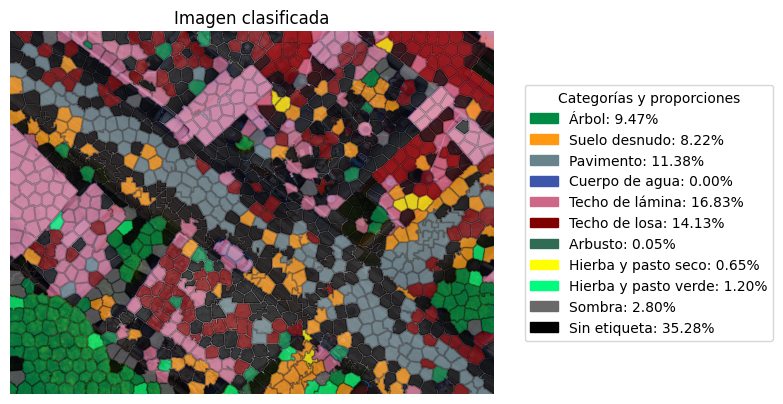

 Imagen pintada exitosamente: image_x5_1272.jpg

 Procesando y pintando imagen: image_x5_1730.jpg



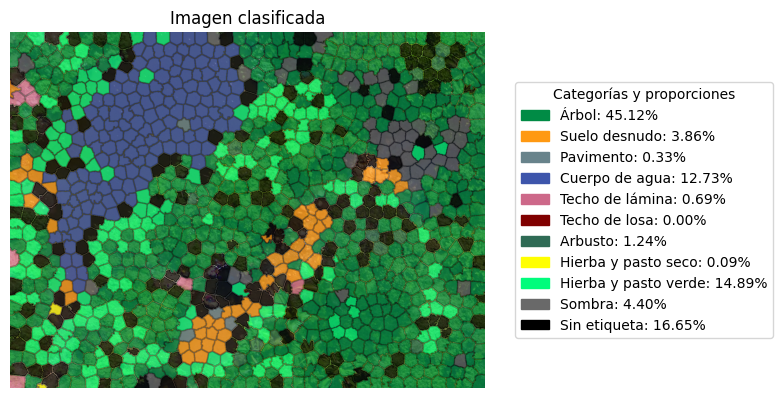

 Imagen pintada exitosamente: image_x5_1730.jpg

 Procesando y pintando imagen: image_x5_250.jpg



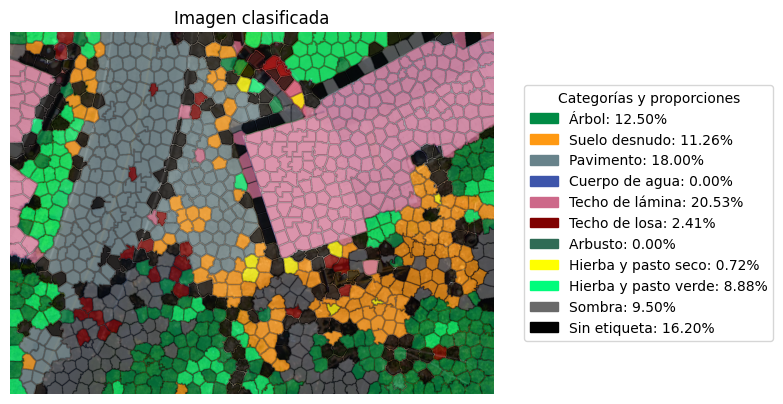

 Imagen pintada exitosamente: image_x5_250.jpg


In [20]:
from funciones_auxiliares_predicciones import img_etiquetas_parallel
import os
import pandas as pd



# Parámetros de segmentación
tamano_superpixeles = 40
ruler = 10
iteraciones = 10
tamano_minimo = 20

# Procesar cada imagen
for imagen in imagenes_jpg:
    print("\n===============================")
    print(f" Procesando y pintando imagen: {imagen}")
    print("===============================\n")
    
    try:
        # Ruta completa a la imagen
        ruta_img = os.path.join(ruta_predicciones_csv, imagen)
        
        # Segmentar imagen
        img_seg, Labels_slic, number_slic = seg_SLIC(
            path_image=ruta_img,
            parametro_1=tamano_superpixeles,
            parametro_2=ruler,
            parametro_3=iteraciones,
            parametro_4=tamano_minimo
        )
        
        # Obtener el nombre base para el CSV
        nombre_base = imagen.replace(".jpg", "")
        nombre_csv = f"Caract_paralelo_{nombre_base}_con_estrategia2.csv"
        ruta_csv = os.path.join(ruta_predicciones_csv, nombre_csv)

        # Cargar el CSV con la columna ya calculada
        df_image_pred = pd.read_csv(ruta_csv)

        # Pintar la imagen con las predicciones
        num_hilos_pintado = 10
        total_time_pintado_parallel, total_time_proporcion = img_etiquetas_parallel(
            df_image_pred["indice"],
            df_image_pred["prediction_actual_dif_estrategia2"],
            Labels_slic,
            ruta_img,
            img_seg,
            num_threads=num_hilos_pintado
        )
        print(f" Imagen pintada exitosamente: {imagen}")

    except Exception as e:
        print(f" Error procesando {imagen}: {e}")
